In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import pennylane as qml
from  pennylane import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from scipy.spatial import distance_matrix
from scipy.stats import chisquare
import plotly

import numpy as npreal
import wandb

import ndtest

from functools import partial

In [2]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hid_size) -> None:
        """
        Args:
        - input_size (int): The size of the input data.
        - hid_size (int): The size of the hidden layers.
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        """
        Performs a forward pass through the Discriminator.

        Args:
        - x (torch.Tensor): The input data.

        Returns:
        - torch.Tensor: The output of the Discriminator.
        """
        return self.layers(x)

    def fit_discriminator(self, x_data, criterion, net_G, optimizer, input_size):
        """
        Trains the Discriminator module.

        Args:
        - x_data (torch.Tensor): The real data.
        - criterion: The loss criterion.
        - net_G: The Generator network.
        - optimizer: The optimizer.
        - input_size (int): The size of the input data.

        Returns:
        - float: The loss value.

        """
        batch_size, _ = x_data.shape[0], x_data.shape[1]
        x_rand = torch.rand((batch_size, input_size))

        self.zero_grad()

        # Forward pass Discriminator on "real" data
        labels_real = torch.ones((batch_size, 1)) * 0.9
        outputs = self.forward(x_data)
        loss_d_real = criterion(outputs, labels_real)

        # Forward pass Discriminator with "fake" data from Generator
        g = net_G(x_rand).detach() # Stop gradients from being updated in generator
        labels_fk = torch.zeros((batch_size, 1)) + 0.1
        outputs = self.forward(g)
        loss_d_fake = criterion(outputs, labels_fk)

        loss_d = loss_d_fake + loss_d_real
        loss_d.backward() # Compute Gradients
        optimizer.step() # Update Weights
        return loss_d.item()

number_of_qubits = 4
number_of_reps = 5

dev = qml.device('default.qubit', wires=number_of_qubits)

@qml.qnode(dev)
def quantum_generator(inputs, params):
    """
    Defines the quantum generator circuit. Embedding and Ansatz layers were based on the paper we followed.

    Args:
    - inputs (torch.Tensor): The input data.
    - params (torch.Tensor): The parameters of the circuit.

    Returns:
    - tuple: The probabilities of the qubits.
    """
    qml.AngleEmbedding(np.pi*(inputs-0.5)/2, rotation="Y", wires=range(number_of_qubits))
    num_params = 0
    for layer in range(number_of_reps):
        #initial Ry gates.
        for i in range(number_of_qubits):
            qml.RY(params[num_params], wires=i)
            num_params += 1

        # Entangling block
        for i in range(number_of_qubits):
            qml.CZ(wires=[i, (i+1)%number_of_qubits])
    return qml.probs(wires=range(number_of_qubits))

weights = {"params": number_of_qubits * number_of_reps}

class Generator(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.q_gen = qml.qnn.TorchLayer(quantum_generator, weights)

    def forward(self, x):
        """
        Performs a forward pass through the Generator.

        Args:
        - x (torch.Tensor): The input data.

        Returns:
        - torch.Tensor: The output of the Generator.
        """
        return self.q_gen(x)

    def fit_generator(self, net_D, T, batch_size, input_size, criterion, optimizer, code_dim, beta):  
        """
        Trains the Generator module.

        Args:
        - net_D: The Discriminator network.
        - T: The T network.
        - batch_size (int): The size of the batch.
        - input_size (int): The size of the input data.
        - criterion: The loss criterion.
        - optimizer: The optimizer.
        - code_dim (int): The dimension of the code.
        - beta (float): The beta value.

        Returns:
        - float: The loss value.
        """
        x_rand = torch.rand((batch_size, input_size))
        self.zero_grad()
        
        # Generate outputs With Generator and check if they fool Discriminator
        labels_real = torch.ones((batch_size, 1)) * 0.9
        g = self.forward(x_rand)
        outputs = net_D(g)

        loss_g = criterion(outputs, labels_real) # We want "fake" Generator output to look real  

        # Compute the MINE loss term: -(E_pxy[T(x,y)] - log(E_pxpy[e^T(x,y)]))
        # Note: term 1 uses joint pdf, term 2 uses marginal pdfs

        x_marg = x_rand[torch.randperm(x_rand.size(0)), 0:code_dim]
        mine = torch.mean(T(g, x_rand[:, 0:code_dim])) - torch.log(torch.mean(torch.exp(T(g, x_marg)))) 
        loss_g += -mine * beta

        loss_g.backward()
        optimizer.step()
        
        return loss_g.item()

class T(nn.Module):
    def __init__(self, noise_dim, code_dim, hid_size) -> None:
        """
        Initializes the T module.

        Args:
        - noise_dim (int): The dimension of the noise.
        - code_dim (int): The dimension of the code.
        - hid_size (int): The size of the hidden layers.
        """
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(code_dim + noise_dim, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, 1)
        )

    def forward(self, gen, codes):
        """
        Performs a forward pass through the T module.

        Args:
        - gen (torch.Tensor): The Generator output.
        - codes (torch.Tensor): The code data.

        Returns:
        - torch.Tensor: The output of the T module.

        """
        return self.layers(torch.cat((gen, codes), dim=1))

    def fit_t(self, net_G, batch_size, input_size, code_dim, optimizer):
        """
        Trains the T module.

        Args:
        - net_G: The Generator network.
        - batch_size (int): The size of the batch.
        - input_size (int): The size of the input data.
        - code_dim (int): The dimension of the code.
        - optimizer: The optimizer.

        Returns:
        - float: The loss value.
        """
        x_rand = torch.rand((batch_size, input_size))
        self.zero_grad()

        # Compute loss following similar logic to MINE term in generator loss
        with torch.no_grad():
            g = net_G(x_rand)
        
        T_out = self.forward(g, x_rand[:, 0:code_dim])
        x_marg = x_rand[torch.randperm(x_rand.size(0)), 0:code_dim]

        t_loss = -(torch.mean(T_out) - torch.log(torch.mean(torch.exp(self.forward(g, x_marg)))))
        t_loss.backward()
        optimizer.step()

        return t_loss.item()


In [3]:
#test the generator
inputs = torch.rand(4)
params = torch.rand(20)
gen = quantum_generator(inputs, params)

# Generate Data Set

In [4]:
def graph_distribution(distribution):
    """
    Graphs the distribution.

    Args:
    - distribution (torch.Tensor): The probability distribution tensor.
    """
    
    # Calculate bin centers
    bin_edges = np.linspace(-0.1, 0.1, 17)  # 16 bins means 17 edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Average of edges to find center

    # Create a bar plot
    plt.figure(figsize=(5, 3))
    plt.bar(bin_centers, distribution, width=bin_edges[1] - bin_edges[0], align='center', color='blue', alpha=0.7)
    plt.xlabel('Return Interval')
    plt.ylabel('Probability')
    plt.title('Probability Distribution of Returns')
    plt.show()

In [5]:
import numpy as np
import yfinance as yf
import pandas as pd

# Function to fetch stock data and calculate daily returns
def fetch_and_process_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    # Calculate daily returns
    daily_returns = stock_data['Adj Close'].pct_change().dropna()
    # Normalize returns to the [-0.1, 0.1] interval
    normalized_returns = np.clip(daily_returns, -0.1, 0.1)
    return normalized_returns

# Fetch and process AAPL and TSLA data
aapl_returns = fetch_and_process_data('AAPL', '2011-01-01', '2022-12-31')
tsla_returns = fetch_and_process_data('TSLA', '2011-01-01', '2022-12-31')

# Ensure both return series are aligned by date
aligned_returns = pd.concat([aapl_returns, tsla_returns], axis=1, join='inner').dropna()

# Separate the aligned data back into AAPL and TSLA returns
aapl_returns, tsla_returns = aligned_returns.iloc[:, 0], aligned_returns.iloc[:, 1]

# Generate Portfolio Returns
num_datasets = 2000
num_bins = 16
datasets = []

for _ in range(num_datasets):
    alpha = np.random.uniform(0, 1)  # Randomly select alpha
    portfolio_returns = alpha * aapl_returns + (1 - alpha) * tsla_returns
    
    # Create Probability Distribution Datasets
    bin_edges = np.linspace(-0.1, 0.1, num_bins+1)
    hist, _ = np.histogram(portfolio_returns, bins=bin_edges)
    datasets.append(hist/len(aapl_returns))

datasets = np.array(datasets)


# 'datasets' now contains 2000 probability distribution datasets,
# each corresponding to a different portfolio composition.


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [6]:
print(sum(datasets[0]))

0.9999999999999999


In [7]:
# def compute_mean_std():
    

# Training

In [8]:
from torch.utils.data import Dataset, DataLoader

class DistributionDataset(Dataset):
    def __init__(self, datasets):
        """
        Initializes the dataset with a list of probability distributions.

        Args:
            distributions (list of list of float): List of probability distributions.
        """
        self.distributions = torch.tensor(datasets, dtype=torch.float32)  # Probability distributions as torch tensor
        
    def __len__(self):
        """
        Returns the total number of distributions in the dataset.
        
        Returns:
            int: The number of distributions in the dataset.
        """
        return len(self.distributions)
    
    def __getitem__(self, idx):
        """
        Retrieves a distribution by index.

        Args:
            idx (int): The index of the distribution to retrieve.

        Returns:
            torch.Tensor: The probability distribution tensor at the given index.
        """
        return self.distributions[idx]



In [23]:

noise_size = 3
code_size = 1
beta = 0.15

net_D = Discriminator(number_of_qubits**2, 24)
# compiled_D = torch.compile(net_D,mode='default')
compiled_D = net_D
net_G = Generator()
compiled_G = net_G
# compiled_G = torch.compile(net_G.forward,mode='default')
net_T = T(number_of_qubits**2, code_size, 20)
compiled_T = net_T
# compiled_T = torch.compile(net_T,mode='default')

batch_size = 80

dataset = DistributionDataset(datasets)
dataloader = DataLoader(dataset, batch_size=batch_size)

criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.rand((512, noise_size + code_size)) 
f0 = fixed_noise.clone()
f5 = fixed_noise.clone()
f1 = fixed_noise.clone()
f0[:, 0] = 0.0
f5[:, 0] = 0.5
f1[:, 0] = 1.0

lrd = 0.0004
lrg = 0.0004
lrt = 0.001
gamma_d = 0.7
gamma_g = 0.7
gamma_t = 0.7

optimizer_D = optim.Adam(compiled_D.parameters(), lr=lrd)
scheduler_D = optim.lr_scheduler.StepLR(optimizer_D, gamma=gamma_d, step_size=30)
optimizer_G = optim.Adam(compiled_G.parameters(), lr=lrg)
scheduler_G = optim.lr_scheduler.StepLR(optimizer_G, gamma=gamma_g, step_size=30)
optimizer_T = optim.Adam(compiled_T.parameters(), lr=lrt)
scheduler_T = optim.lr_scheduler.StepLR(optimizer_T, gamma=gamma_t, step_size=30)

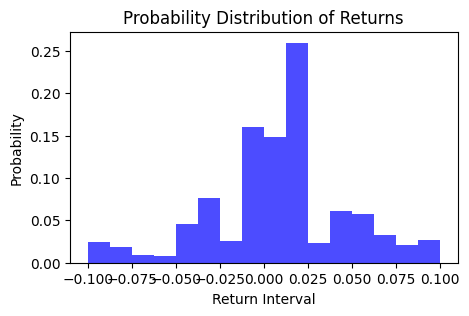

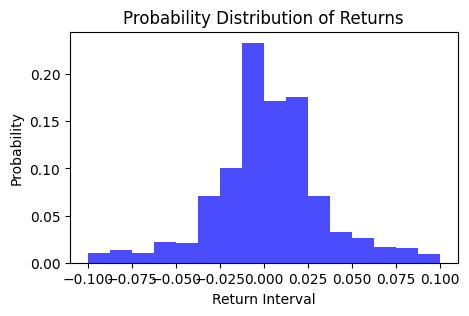

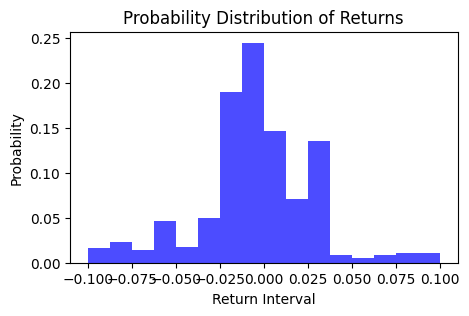

Epoch:  321
Epoch:  322
Epoch:  323
Epoch:  324
Epoch:  325
Epoch:  326
Epoch:  327


d_loss,█▂▁▁▁▅▇█▇▅▅▃▃▃▃▃▂▃▃▃▃▃▂▃▃▂▃▃▃▂▂▃▃▃▃▃▂▃▂▃
g_loss,▁▄▇▇█▅▂▁▁▁▃▄▄▅▆▅▆▅▆▅▅▆▅▅▅▆▇▇▆▇▆▅▆▆▅▅▇▆▆▇
t_loss,█▆▆▆▆▅▆▆▅▅▅▃▄▄▄▄▄▅▃▃▄▂▃▂▃▂▄▂▃▃▃▂▃▁▃▃▃▂▃▂
d_loss,0.79914
g_loss,1.583
t_loss,-2.11349


In [30]:
d_error = []
g_error = []
t_error = []
fk_prog = []
epochs = 450

# wandb.init(
#     project='InfoQGAN',
#     config = {
#         "Generator Architecture": str(dict(net_G.named_modules())),
#         "Discriminator Architecture": str(dict(net_D.named_modules())),
#         "T Architecture": str(dict(net_T.named_modules())),
#         "Batch Size": batch_size
#     }
# )

for _ in range(450-122):
    for batch in dataloader:
        # First Update Discriminator with batch of Real Data
        d_loss = compiled_D.fit_discriminator(batch, criterion, compiled_G, optimizer_D, noise_size+code_size)
        g_loss = compiled_G.fit_generator(compiled_D, net_T, batch_size, noise_size+code_size, criterion, optimizer_G, code_size, beta)
        t_loss = compiled_T.fit_t(compiled_G, batch_size, noise_size+code_size, code_size, optimizer_T)

        # print("Batch done")
        d_error.append(d_loss)
        g_error.append(g_loss)
        t_error.append(t_loss)
        wandb.log({"d_loss": d_loss, "g_loss": g_loss, "t_loss": t_loss})
    
    print("Epoch: ", _)
    scheduler_D.step()
    scheduler_G.step()
    scheduler_T.step()
    # with torch.no_grad():
    #     fake = compiled_G(fixed_noise)
    #     x_c1 = npreal.cov(fake[:, 0].detach().numpy(), fixed_noise[:, 0])[0][1]
    #     y_c1 = npreal.cov(fake[:, 1].detach().numpy(), fixed_noise[:, 0])[0][1]
        # wandb.log({"Code 0 - X axis": x_c1, "Code 0 - Y axis": y_c1})

    if _ % 20 == 0:
        with torch.no_grad():
            fake0 = compiled_G(f0)
            fake5 = compiled_G(f5)
            fake1 = compiled_G(f1)
            clear_output(wait=True)
            graph_distribution(torch.mean(fake0, dim=0).detach().numpy())
            graph_distribution(torch.mean(fake5, dim=0).detach().numpy())
            graph_distribution(torch.mean(fake1, dim=0).detach().numpy())
            

wandb.finish()

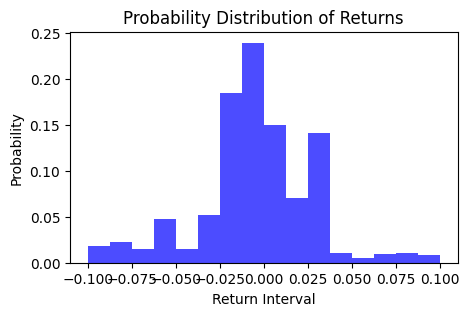

In [31]:
#Generate 10 samples of data with codes between 0 and 1 in incremenets of 0.1
noise = torch.rand(512, 4)
noise[:,0] = 1
samples = compiled_G(noise)

sample = torch.mean(samples, dim=0).detach().numpy()
graph_distribution(sample)



In [113]:
torch.save(compiled_G.state_dict(), './models/dauntless-surf-96.pth')

In [32]:
#Generate 10 samples of data with codes between 0 and 1 in incremenets of 0.1
def get_mean_sample(num_sampls, code):
    with torch.no_grad():
        noise = torch.rand(512, 4)
        noise[:,0] = code
        samples = compiled_G(noise)

    sample = torch.mean(samples, dim=0)
    return sample

def calculate_sample_mean(sample):
    sum = 0
    for i in range(len(sample)):
        return_value = (-0.1 + (0.2) * i / (len(sample))) + 0.2/32
        sum += return_value*sample[i]
    return sum

In [33]:
codes = np.linspace(0, 1, 16)
number_of_samples = 512
x = []
y = []

for code in codes:
    sample = get_mean_sample(number_of_samples, code)
    x.append(np.std(sample.numpy()))
    y.append(calculate_sample_mean(sample))

Text(0, 0.5, 'Mean')

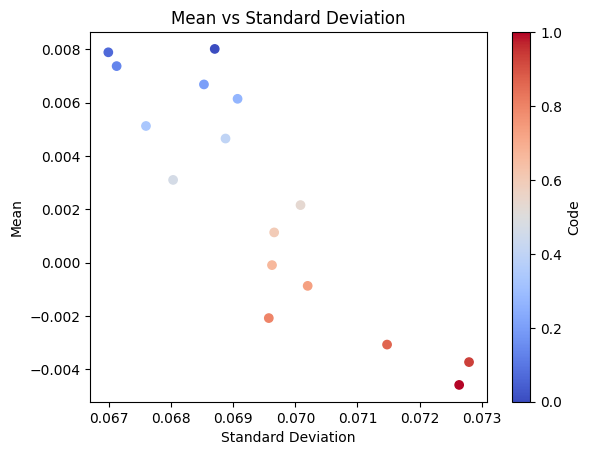

In [40]:
#plot line graph of the data
# Sample data - replace with your actual data
data = {
    'Standard Deviation': x,
    'Mean': y,
    'Code': codes
}

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Plot the data
plt.scatter(df['Standard Deviation'], df['Mean'], c=df['Code'], cmap='coolwarm')

# Adding a color bar
plt.colorbar(label='Code')

# Adding titles and labels
plt.title('Mean vs Standard Deviation')
plt.xlabel('Standard Deviation')
plt.ylabel('Mean')

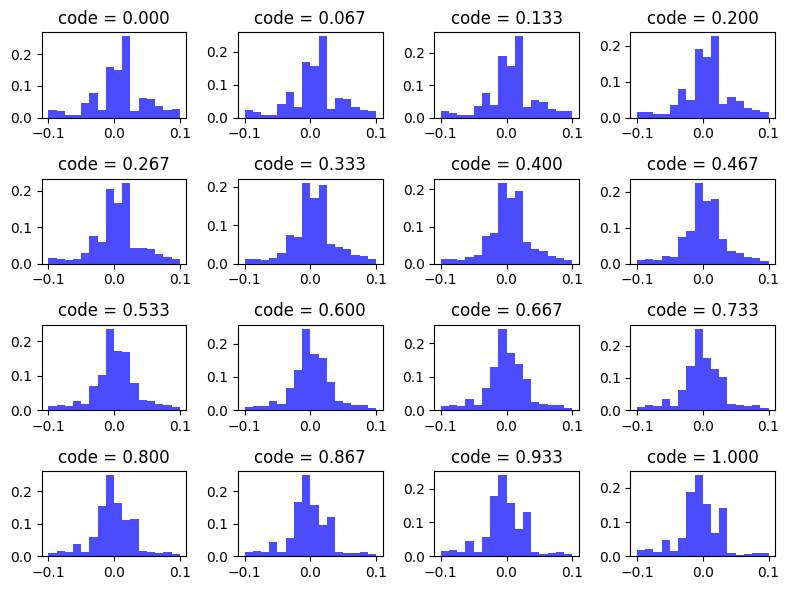

In [35]:
import matplotlib.pyplot as plt

# Your existing method to generate a plot for a given code value
def generate_plot(ax, code):
    """
    Graphs the distribution.

    Args:
    - distribution (torch.Tensor): The probability distribution tensor.
    """
    distribution = get_mean_sample(512, code)
    # Calculate bin centers
    bin_edges = np.linspace(-0.1, 0.1, 17)  # 16 bins means 17 edges
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Average of edges to find center

    # Create a bar plot
    ax.bar(bin_centers, distribution, width=bin_edges[1] - bin_edges[0], align='center', color='blue', alpha=0.7)
    pass

# Set up a grid of 4x4 subplots
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(8, 6))
codes = np.linspace(0,1,16)  # Example list of codes from 0 to 1

# Fill the grid with plots
for ax, code in zip(axes.flatten(), codes):
    generate_plot(ax, code)
    ax.set_title(f'code = {code:.3f}')  # Setting title with rounded code value

plt.tight_layout()
plt.show()